In [44]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import pandas as pd
import numpy as np
from pandas import concat
from collections import Counter

import xgboost
import os
import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import pickle
import logging
import matplotlib.pyplot as plt
import timeit

NUMBER_OF_TREES = 50
WINDOW_SIZE = 5

TARGET_COLUMN = 'flow_size'

def calculate_scaling(training_paths): #### returns max value in each column
    scaling = {}
    #calculate scaling factors
    for f in training_paths:
        df = pd.read_csv(f, index_col=False)

        for column in df.columns:
            if column not in scaling:
               scaling[column] = 0.
            scaling[column] = max(scaling[column], float(df[column].max()))
    return scaling

def resize(s,scaling):
    return s/scaling[s.name]

def prepare_files(files, window_size, scaling, target_column='flow_size'):
    result = []

    for f in files:
        df = pd.read_csv(f, index_col=False)
        cols_to_drop = 
        df = df.drop("index", axis=1)
        flow_size = df[target_column].to_numpy()
        thresh = 1e6
        flow_size = np.where(flow_size>=thresh, 1, -1)
        counter = Counter(flow_size)

        df = df.apply((lambda x: resize(x, scaling)), axis=0)
        df[target_column] = flow_size
        columns = list(df)
        
        df[target_column] = flow_size
        
        #extend the window
        columns = list(df)
        final_df = df.copy()
        for sample_num in range(1, window_size): ### doing the time series (but why?? - data for previous k flows?)
            shifted = df.shift(sample_num)
            shifted.columns = map(lambda x: x+str(sample_num), shifted.columns)
            final_df = concat([shifted, final_df], axis=1)

        final_df = final_df.fillna(0)
        final_df = final_df.drop(target_column, axis=1)

        result.append((final_df, flow_size))
    return result
        

def make_io(data):
    inputs = None
    outputs = None
    for d in data:
        i_data = d[0].to_numpy()
        o_data = d[1].tolist()

        if inputs is None:
            inputs = i_data
            outputs = o_data
        else:
            inputs = np.append(inputs, i_data, axis=0)
            outputs = np.append(outputs, o_data)
    return (inputs, outputs)


In [49]:
random.seed(0)

# TRAINING_PATH = 'data/ml/' + TEST_NAME + '/training/'
# TEST_PATH = 'data/ml/' + TEST_NAME + '/test/'
# VALIDATION_PATH = 'data/ml/' + TEST_NAME + '/validation/'
# MODEL_SAVE_PATH = 'model/xgboost/model_' + TEST_NAME + '.pkl'
# # LOG_PATH = 'model/xgboost/log_' + TEST_NAME + '.log'
# PLOT_PATH = 'results/xgboost/' + TEST_NAME

# # logging.basicConfig(level=logging.DEBUG)
# # file_handler = logging.FileHandler(LOG_PATH)

# training_files = [os.path.join(TRAINING_PATH, f) for f in os.listdir(TRAINING_PATH)]
# test_files = [os.path.join(TEST_PATH, f) for f in os.listdir(TEST_PATH)]
# validation_files = [os.path.join(VALIDATION_PATH, f) for f in os.listdir(VALIDATION_PATH)]

# scaling = xgboost_util.calculate_scaling(training_files)
# data = xgboost_util.prepare_files(training_files, WINDOW_SIZE, scaling, TARGET_COLUMN)

# inputs, outputs = xgboost_util.make_io(data)

TRAINING_PATH = 'C:/D-drive-18921/College/Cloud Computing/flux/data/ml/KMeans/training/'
TEST_PATH = 'C:/D-drive-18921/College/Cloud Computing/flux/data/ml/KMeans/test/'
VALIDATION_PATH = 'C:/D-drive-18921/College/Cloud Computing/flux/data/ml/KMeans/validation/'

training_files = [os.path.join(TRAINING_PATH, f) for f in os.listdir(TRAINING_PATH)]
validation_files = [os.path.join(VALIDATION_PATH, f) for f in os.listdir(VALIDATION_PATH)]

scaling = calculate_scaling(training_files)

data = prepare_files(training_files, WINDOW_SIZE, scaling, TARGET_COLUMN)
inputs, outputs = make_io(data)
counter = Counter(outputs)


In [52]:
estimate = counter[-1]/counter[1]
print(estimate)
##A sensible default value to set for the scale_pos_weight hyperparameter is the inverse of the class distribution.

0.02401697944593387


In [60]:
validation_files = [os.path.join(VALIDATION_PATH, f) for f in os.listdir(VALIDATION_PATH)]
test_files = [os.path.join(TEST_PATH, f) for f in os.listdir(TEST_PATH)]
# # fit model no training data
# param = {
#     'num_epochs': NUMBER_OF_TREES,
#     'max_depth': 10,
#     'objective': 'reg:linear',
#     'booster': 'gbtree',
#     'base_score': 2,
#     'silent': 1,
#     'eval_metric': 'mae'
# }

# training = xgboost.DMatrix(inputs, outputs, feature_names=data[0][0].columns)
# print(len(outputs))
# print('Training started')
# model = xgboost.train(param, training, param['num_epochs'])
# pickle.dump(model, open(MODEL_SAVE_PATH, "wb"))

data_val = prepare_files(validation_files, WINDOW_SIZE, scaling, TARGET_COLUMN)
inputs_val, outputs_val = make_io(data_val)

data_test = prepare_files(test_files, WINDOW_SIZE, scaling, TARGET_COLUMN)
inputs_test, outputs_test = make_io(data_test)


In [87]:
len(data[0][0].columns)

74

## Random Forest

In [79]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
rf = RandomForestClassifier(n_estimators=50, class_weight='balanced')
rf = rf.fit(inputs, outputs)


In [88]:
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = data[0][0].columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
feature_importances

,importance
tcp_queue1,0.154422
first_call,0.134352
machine1,0.131018
agg_net_in_per_machine1,0.079981
agg_net_out,0.054948
...,...
ram4,0.000425
machine4,0.000328
flow_size4,0.000280
flow_size2,0.000104


In [80]:
predictions = rf.predict(inputs_val)
predictions2 = rf.predict(inputs_test)

0.99631277813096


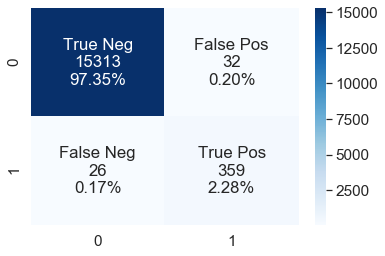

In [81]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = confusion_matrix(outputs_test,predictions2)
print(accuracy_score(outputs_test,predictions2))
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                df_cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     df_cm.flatten()/np.sum(df_cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
# sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=labels, fmt='', cmap='Blues')

plt.show()

## MLP Classifier

0.9956770502225047


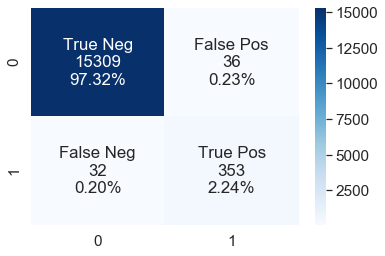

In [76]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(5, 5), activation='relu')#, alpha=0.0001)
mlp.fit(inputs, outputs)
mlp_predictions = mlp.predict(inputs_test)
acc_mlp = accuracy_score(outputs_test, mlp_predictions)
print(acc_mlp)
cm_mlp = confusion_matrix(outputs_test, mlp_predictions)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cm_mlp.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cm_mlp.flatten()/np.sum(cm_mlp)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sn.heatmap(cm_mlp, annot=labels, fmt='', cmap='Blues')
plt.show()